In [18]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model

tf.get_logger().setLevel('ERROR')
log_dir='logs_feta'
models_dir='models_feta'
checkpoint_path='weights_epoch_2300.h5'
data_dir = 'feta_2d/'

import numpy as np
nb_labels=2
dimx=256
dimy=256
nb_features=64
batch_size=8
warp_max=2   
warp_max=2.5
warp_min=.5
warp_blur_min=np.array([2, 4, 8])
warp_blur_max=warp_blur_min*2
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2
initial_lr=1e-4
lr = 1e-4
lr_lin = 1e-4
nb_levels=5
conv_size=3
num_epochs=40000

def dice_coefficient(y_true, y_pred):
    ndims = len(y_pred.get_shape().as_list()) - 2
    vol_axes = list(range(1, ndims + 1))

    top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    div_no_nan = tf.math.divide_no_nan if hasattr(
    tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
    dice = tf.reduce_mean(div_no_nan(top, bottom))
    return dice
    
def load_data(data_dir):
    
    subject_dirs = [d for d in os.listdir(data_dir) if d.startswith('sub-')]
    seg_image_filenames = []
    real_image_filenames = []
    fetal_data = []  # List to store fetal images
    fetal_segmentation_masks = []  # List to store fetal segmentation masks
    
    for subject_dir in subject_dirs:
        subject_prefix = subject_dir
    
        # Search for the T2-weighted image and segmented brain image with flexible naming patterns
        t2w_path = None
        dseg_path = None
        # print(os.path.join(data_dir, subject_prefix))
        for filename in os.listdir(os.path.join(data_dir, subject_prefix)):
            if "_T2w.nii.gz" in filename:
                t2w_path = os.path.join(data_dir, subject_prefix, filename)
            elif "_dseg.nii.gz" in filename:
                dseg_path = os.path.join(data_dir, subject_prefix, filename)
    
        if t2w_path is None or dseg_path is None:
            print(f"Data not found for subject {subject_prefix}. Skipping...")
            continue
    
        # Append the filenames to the respective lists
        real_image_filenames.append(t2w_path)
        seg_image_filenames.append(dseg_path)
        
    for i in range(len(real_image_filenames)):
        # Load the 2D image
        img_path = real_image_filenames[i]
        real_img = nib.load(img_path).get_fdata()

        seg_img_path = seg_image_filenames[i]
        seg_img = nib.load(seg_img_path).get_fdata()

        min_value = np.min(real_img)
        max_value = np.max(real_img)
        real_img = (real_img - min_value) / (max_value - min_value)

        real_img = tf.expand_dims(real_img, axis=0)  # Shape becomes (1, 160, 192, 1)
        fetal_data.append(real_img)
        fetal_segmentation_masks.append(seg_img)
    return fetal_data, fetal_segmentation_masks

def load_model(checkpoint):
    in_shape = (dimx,dimy)
    # unet_model = models.unet(input_shape=(dimx, dimy, 1), nb_features=nb_features, nb_labels=nb_labels, nb_levels=nb_levels, conv_size=conv_size)
    input_img = Input(shape=(dimx, dimy,1))
    gen_arg = dict(
            in_shape=in_shape,
            labels_in=[i for i in range(nb_labels)],#np.unique(input_image[0]).astype(int),#np.unique(input_image),
            warp_min=0.01,
            warp_max=2,
            zero_background=1
        )
    gen_model_1 = ne.models.labels_to_image_new(**gen_arg, id=1)
    generated_img, y = gen_model_1(input_img)
    unet_model = models.unet(input_shape=(dimx, dimy, 1), nb_features=nb_features, nb_labels=nb_labels, nb_levels=nb_levels, conv_size=conv_size)
    segmentation = unet_model(generated_img)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    
    combined_model.load_weights(os.path.join(models_dir,checkpoint))
    
    unet_from_combined = combined_model.get_layer('unet') # Make sure the name matches the U-Net layer's name in the combined model
    unet_from_combined.save_weights(models_dir+'/unet_only_weights.h5')
    
    unet_model = models.unet(input_shape=(dimx, dimy, 1), nb_features=nb_features, nb_labels=nb_labels, nb_levels=nb_levels, conv_size=conv_size)
    unet_model.load_weights(models_dir+'/unet_only_weights.h5')
    return unet_model
    
fetal_data, fetal_segmentation_masks = load_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(fetal_data, fetal_segmentation_masks, test_size=0.2, random_state=42)

unet_model = load_model(checkpoint_path)

train_dice_coefficients = []
test_dice_coefficients = []


for i in range(len(X_train)):
    real_img = X_train[i]
    seg_img = y_train[i]

    # Ensure that the input has the correct shape (None, 256, 256, 1)
    real_img = tf.expand_dims(real_img, axis=-1)  # Shape becomes (1, dimx, dimy, 1)

    y_pred = unet_model.predict(real_img, verbose=0)

    y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

    train_dice = dice_coefficient(seg_img, y_pred)
    train_dice_coefficients.append(train_dice)



y_preds=[]
# Calculate Dice coefficient for the testing set
for i in range(len(X_test)):
    real_img = X_test[i]
    seg_img = y_test[i]

    real_img = tf.expand_dims(real_img, axis=-1)  # Shape becomes (1, dimx, dimy, 1)
    y_pred = unet_model.predict(real_img, verbose=0)

    y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    y_preds.append(y_pred)
    test_dice = dice_coefficient(seg_img, y_pred)
    test_dice_coefficients.append(test_dice)

# Calculate the average Dice coefficients for training and testing sets
average_train_dice = np.mean(train_dice_coefficients)
average_test_dice = np.mean(test_dice_coefficients)

print(f"Average Dice coefficient for the training set: {average_train_dice}")
print(f"Average Dice coefficient for the testing set: {average_test_dice}")

using final_pred_activation softmax for unet
using final_pred_activation softmax for unet
Average Dice coefficient for the training set: 0.8500969805008689
Average Dice coefficient for the testing set: 0.8362521090169155


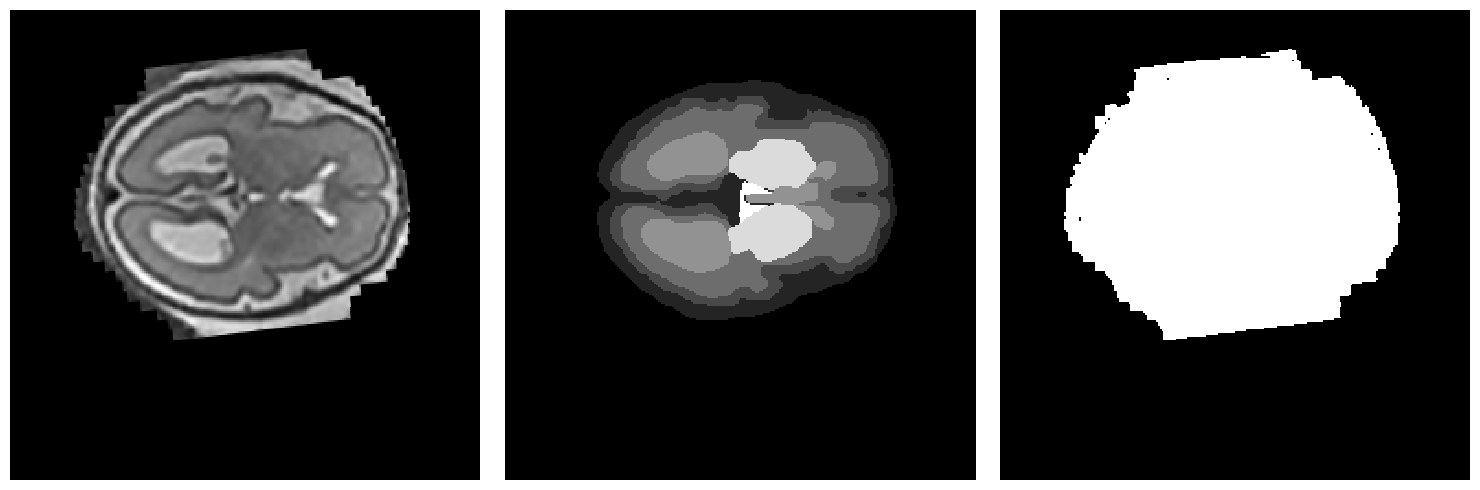

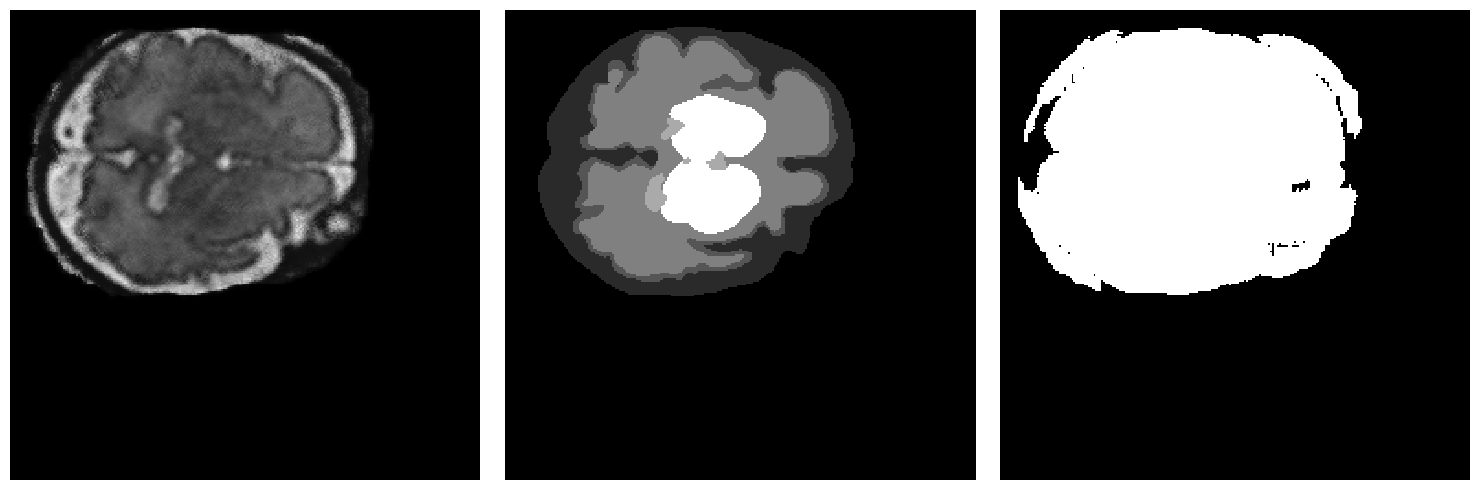

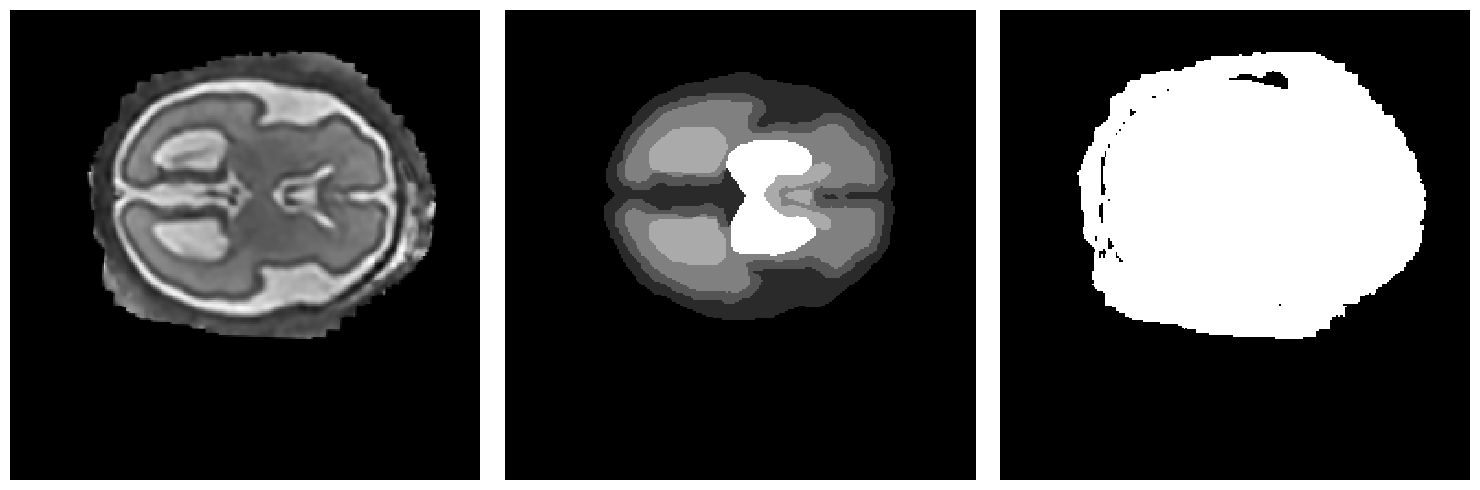

In [19]:
for i in range(3):
    ne.plot.slices(slices_in=(X_test[i], y_test[i], y_preds[i]), cmaps=['gray', 'gray', 'gray'])
